## Import Data & Libraries

In [ ]:
from matplotlib import pyplot as plt
import json
import numpy as np
import re
import random
import pandas as pd
import pickle

import datetime
from datetime import timedelta

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
total=pd.read_json("/content/drive/MyDrive/NLP_News/Data/total.json")
total.head()

,id,created_at,tweet,username,ALL
0,679451396844990465,2015-12-23 00:00:11,gulf nations demand release of abducted qatari...,ajenews,"[iraq, qataris, gulf nations]"
1,679451620514611201,2015-12-23 00:01:04,midway through enrollment season for president...,ap,[obama]
2,679452844307705856,2015-12-23 00:05:56,russia bombs kill syria civilians,bbcworld,"[syria, russia]"
3,679453367106678785,2015-12-23 00:08:01,six republican candidates expected in fox busi...,cnn,"[fox, republican, six]"
4,679453408324108288,2015-12-23 00:08:10,video bagpipes amid the bustle in tokyo,bbcworld,[tokyo]


In [ ]:
cols = ['text', 'date', 'NE', 'similar_ind', 'all_ind', 'sentiment','similar','t_sent']
truedata=pd.read_csv("/content/drive/MyDrive/NLP_News/Test_data/t_true.csv",usecols=cols,skipinitialspace=True,encoding = "ISO-8859-1")
fakedata=pd.read_csv("/content/drive/MyDrive/NLP_News/Test_data/t_fake.csv",usecols=cols,skipinitialspace=True,encoding = "ISO-8859-1")

In [ ]:
# data_t.drop_duplicates(subset ="text", inplace = True) 
# data_t= data_t.reset_index(drop=True)
# data_f.drop_duplicates(subset ="text", inplace = True) 
# data_f= data_f.reset_index(drop=True)

# data_t.sort_values(by=['date'], inplace=True)
# data_t= data_t.reset_index(drop=True)
# data_f.sort_values(by=['date'], inplace=True)
# data_f= data_f.reset_index(drop=True)

## Similar Check

In [ ]:
!pip3 install fasttext

     |████████████████████████████████| 68 kB 3.1 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3122432 sha256=4ff727d162ab4bdca553b7a28f45653a3817fd9920faeee3f2a44cd56c262c43
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English

'cc.en.300.bin'

In [1]:
ft_sim = fasttext.load_model('cc.en.300.bin')
ft_sim.get_dimension()

NameError: ignored

In [ ]:
def cos_sim(a, b):	
	dot_product = np.dot(a, b)
	norm_a = np.linalg.norm(a)
	norm_b = np.linalg.norm(b)
	return dot_product / (norm_a * norm_b)

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords  
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  
def similar_delete(x,y):
  t1 = [word_tokenize(i) for i in x]
  t2 = [word_tokenize(i) for i in y]
  for i in t1[0]:
    for j in t2[0]:
      if j==i:
        # print(i,j)
        t1[0] = list(filter((i).__ne__,t1[0]))
        t2[0] = list(filter((j).__ne__,t2[0]))
  for j in t2[0]:
    if j in stop_words:
      t2[0] = list(filter((j).__ne__,t2[0]))
  for i in t1[0]:
    if i in stop_words:
      t1[0] = list(filter((i).__ne__,t1[0]))

  x=' '.join(word for word in t1[0])
  y=' '.join(word for word in t2[0])
  return x,y


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import ast 
for i in range(truedata.shape[0]):
  truedata.similar_ind[i]=ast.literal_eval(truedata.similar_ind[i]) 
for i in range(fakedata.shape[0]):
  fakedata.similar_ind[i]=ast.literal_eval(fakedata.similar_ind[i]) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
def sim_score(dataset,total,types):
  similar=[]
  for i in range(dataset.shape[0]):
    x=[]
    if dataset.similar_ind[i]==-1:
      x.append(None)
    else:
      for j in dataset.similar_ind[i]:
        d_a=dataset.text[i]
        d_b=total.tweet[j]
        if types==1:
          d_a,d_b=similar_delete([d_a],[d_b])
        if len(d_a)==0:
          d_a=d_a+" a"
        if len(d_b)==0:
          d_b=d_b+" a"
        a = ft_sim.get_sentence_vector(str(d_a))
        b = ft_sim.get_sentence_vector(str(d_b))
        x.append(cos_sim(a,b))
    similar.append(x)
    dataset["similar"]=similar
  return dataset

In [2]:
fakedata=sim_score(fakedata,total,types=0)
truedata=sim_score(truedata,total,types=0)

In [3]:
# fakedata=sim_score(fakedata,total,types=1)
# truedata=sim_score(truedata,total,types=1)

In [ ]:
truedata["veracity"]=np.array(0)
fakedata["veracity"]=np.array(1)
testdata=truedata.append(fakedata,ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
max=[]
min=[]
mean=[]
for i in testdata["similar"]:
  max.append(np.max(i))
  min.append(np.min(i))
  mean.append(np.mean(i))
testdata["max_sim"]=max
testdata["min_sim"]=min
testdata["mean_sim"]=mean

# max=[]
# min=[]
# mean=[]
# for i in testdata["similar_deleted"]:
#   max.append(np.max(i))
#   min.append(np.min(i))
#   mean.append(np.mean(i))
# testdata["max_sim_del"]=max
# testdata["min_sim_del"]=min
# testdata["mean_sim_del"]=mean

## Sentiment Check

In [ ]:
import fasttext
ft_sent = fasttext.load_model('/content/drive/MyDrive/NLP_News/model_amzn.bin')

In [ ]:
x=[]
for i in range(testdata.shape[0]):
  sent_t=ft_sent.predict(testdata.text[i])[0][0]
  prop_t=ft_sent.predict(testdata.text[i])[1][0]
  sent_t=sent_t.replace("__label__", "")
  if prop_t<0.5:
    x.append(0)
  elif int(sent_t)==2:
    x.append(1)
  elif int(sent_t)==1:
    x.append(-1)
testdata["fasttext_sent"]=x


similar=[]
for i in range(testdata.shape[0]):
  x=[]
  for j in testdata.similar_ind[i]:
    sent_t=ft_sent.predict(total.tweet[j])[0][0]
    sent_t=sent_t.replace("__label__", "")
    if float(sent_t)<0.5:
      x.append(0)
    elif int(sent_t)==2:
      x.append(1)
    elif int(sent_t)==1:
      x.append(-1)
  y=np.argmin(abs(np.array(x)-testdata.fasttext_sent[i]))
  similar.append(x[y])
testdata["t_sent_ft"]=similar


for i in range(testdata.shape[0]):
  testdata.fasttext_sent[i]=testdata.fasttext_sent[i]-testdata.t_sent_ft[i]

# for i in range(testdata.shape[0]):
  # testdata.sentiment[i]=testdata.sentiment[i]-testdata.t_sent[i]

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
def check_sent(dataset):
  sent=[]
  for i in range(dataset.shape[0]):
    tweet=dataset.text[i]
    x=sid.polarity_scores(tweet)["compound"]
    sent.append(x)
  dataset["sentiment_lex"]=sent
  return dataset

testdata=check_sent(testdata)


similar=[]
for i in range(testdata.shape[0]):
  x=[]
  for j in testdata.similar_ind[i]:
    sent_t=sid.polarity_scores(str(total.tweet[j]))["compound"]
    x.append(sent_t)
  y=np.argmin(abs(np.array(x)-testdata.sentiment_lex[i]))
  similar.append(x[y])
testdata["t_sent_lex"]=similar


for i in range(testdata.shape[0]):
  testdata.sentiment_lex[i]=testdata.sentiment_lex[i]-testdata.t_sent_lex[i]

In [ ]:
for i in range(testdata.shape[0]):
  x=testdata.sentiment_lex[i]
  if x<=-0.5:
    testdata["sentiment_lex"][i]=1
  elif x<=0:
    testdata["sentiment_lex"][i]=2
  elif x<=0.5:
    testdata["sentiment_lex"][i]=3
  elif x<=1:
    testdata["sentiment_lex"][i]=4

  x=testdata.t_sent_lex[i]
  if x<=-0.5:
    testdata["t_sent_lex"][i]=1
  elif x<=0:
    testdata["t_sent_lex"][i]=2
  elif x<=0.5:
    testdata["t_sent_lex"][i]=3
  elif x<=1:
    testdata["t_sent_lex"][i]=4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: Set

In [ ]:
testdata.sample(10)

,text,date,ALL,similar_ind,all_ind,sentiment,similar,t_sent,similar_deleted,veracity,max_sim,min_sim,mean_sim,max_sim_del,min_sim_del,mean_sim_del,fasttext_sent,sentiment_lex,t_sent_lex,t_sent_ft
2808,this amazing photo shows the power women have ...,2016-04-20 00:00:00,[],[56337],"[55059, 55060, 55113, 55114, 55128, 55132, 551...",1,[0.76611495],1,[0.44518688],1,0.766115,0.766115,0.766115,0.445187,0.445187,0.445187,1,4.0,4.0,1
3763,here s why mega band u is blaming trump for de...,2017-01-12 00:00:00,[],[182527],"[182233, 182254, 182299, 182310, 182317, 18233...",0,[0.8822005],1,[0.48308703],1,0.882200,0.882200,0.882200,0.483087,0.483087,0.483087,1,1.0,2.0,1
2612,window falls from u s marines helicopter onto ...,2017-12-13 00:00:00,"['u s marines', 'japan', 'okinawa']",[350604],[350604],0,[0.8100173],0,[0.37919313],0,0.810017,0.810017,0.810017,0.379193,0.379193,0.379193,-1,2.0,2.0,-1
1952,russia vetoes extension of mission probing che...,2017-10-24 00:00:00,"['russia', 'syria']","[327132, 327159]","[327086, 327132, 327159, 327186, 328422]",0,"[0.84516215, 0.91602606]",0,"[0.4603929, 0.39988327]",0,0.916026,0.845162,0.880594,0.460393,0.399883,0.430138,1,2.0,2.0,1
585,trump says u s mexico border wall to come soon...,2017-01-25 00:00:00,"['mexico', 'abc', 'trump', 'u s']",[190252],"[189208, 189517, 189644, 190166, 190252, 19028...",1,[0.84538555],0,[0.4392356],0,0.845386,0.845386,0.845386,0.439236,0.439236,0.439236,1,2.0,2.0,1
1881,uk pm may heads to brussels expecting construc...,2017-10-16 00:00:00,"['brussels', 'uk']",[324982],[324982],1,[0.7775439],1,[0.32862455],0,0.777544,0.777544,0.777544,0.328625,0.328625,0.328625,-1,2.0,2.0,1
3916,trump put out a survey on the media and what h...,2017-02-19 00:00:00,['trump'],[202690],"[200981, 200985, 201028, 201048, 201061, 20111...",1,[0.65339875],0,[0.27229324],1,0.653399,0.653399,0.653399,0.272293,0.272293,0.272293,1,2.0,2.0,-1
18,u s iran discuss fulfilling nuclear deal pledg...,2016-04-19 00:00:00,"['iran', 'tehran', 'u s']",[57218],[57218],0,[0.7947421],1,[0.44285467],0,0.794742,0.794742,0.794742,0.442855,0.442855,0.442855,1,2.0,2.0,1
3277,hilarious what a trump ad for black voters wou...,2016-08-24 00:00:00,[],[117084],"[115461, 115465, 115518, 115580, 115596, 11569...",0,[0.81299937],1,[0.49359953],1,0.812999,0.812999,0.812999,0.493600,0.493600,0.493600,-1,4.0,1.0,-1
1612,spain catalonia clash over policing as illegal...,2017-09-23 00:00:00,['spain catalonia'],[312200],"[312200, 313595, 313657, 313853]",0,[0.9319379],0,[0.5351186],0,0.931938,0.931938,0.931938,0.535119,0.535119,0.535119,-1,1.0,1.0,1


## Emotion Check

In [4]:
!pip install text2emotion

In [5]:
import text2emotion as te

In [ ]:
angry=[]
sad=[]
happy=[]
fear=[]
surprise=[]

for i in range(testdata.shape[0]):
  t_emotion=te.get_emotion(testdata.text[i])
  angry.append(t_emotion["Angry"])
  sad.append(t_emotion["Sad"])
  fear.append(t_emotion["Fear"])
  happy.append(t_emotion["Happy"])
  surprise.append(t_emotion["Surprise"])
testdata["angry"]=angry
testdata["sad"]=sad
testdata["fear"]=fear
testdata["happy"]=happy
testdata["surprise"]=surprise

## Result

In [ ]:
testdata=testdata[843:]
testdata.reset_index(inplace=True)

In [ ]:
def set_bound(Y_pre,Y_test,X_test,m,p):
  for i in range(m.shape[0]):
    g=Y_pre[i]
    if g==0:
      if m[i][0]<p:
        Y_pre[i]=2
    if g==1:
      if m[i][1] < p:
        Y_pre[i]=2
  # d_l=[]
  # for i in range(len(Y_pre)):
    # if Y_pre[i]==2:
      # d_l.append(i)
  # Y_pre=np.delete(Y_pre,d_l,axis=0)
  # Y_test=np.delete(Y_test,d_l,axis=0)
  # X_test=np.delete(X_test,d_l,axis=0)
  return Y_pre,Y_test,X_test

In [ ]:
X =np.column_stack((testdata["fasttext_sent"],testdata["min_sim"],testdata["angry"],testdata["sad"],testdata["fear"],testdata["happy"],testdata["surprise"]))
Y = testdata["veracity"].tolist()
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0,train_size=3000)
print(X_train.shape)

(3000, 7)


In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)

In [ ]:
Y_pre=clf.predict(X_test)
a=clf.predict_proba(X_test)
Y_pre,Y_test,X_test=set_bound(Y_pre,Y_test,X_test,a,0.75)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


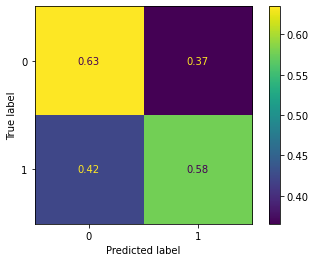

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(Y_test, Y_pre)
plot_confusion_matrix(clf, X_test, Y_test, normalize='true')

In [ ]:
from sklearn.metrics import recall_score, precision_score,accuracy_score,roc_auc_score
print("For Fake:\n")
print("Recall",recall_score(Y_test, Y_pre, pos_label=1))
print("Precision",precision_score(Y_test,Y_pre, pos_label = 1))
print("\nFor True:\n")
print("Recall",recall_score(Y_test, Y_pre, pos_label=0))
print("Precision",precision_score(Y_test,Y_pre, pos_label = 0))
print("\nAccuracy",accuracy_score(Y_test, Y_pre))
print("\nroc_auc_score",roc_auc_score(Y_test, Y_pre))

For Fake:

Recall 0.5776699029126213
Precision 0.6025316455696202

For True:

Recall 0.6348837209302326
Precision 0.610738255033557

Accuracy 0.6068883610451307

roc_auc_score 0.6062768119214269


In [ ]:
from sklearn import tree
from sklearn.model_selection import learning_curve
clf = tree.DecisionTreeClassifier()
train_sizes = [500,600,700,800,900,1000,1200,1400,1600,1800,2000,2200,2400,2800,3000]
train_sizes, train_scores, test_scores = learning_curve(estimator = clf,
                                                              X = X,y = Y,
                                                              train_sizes = train_sizes,
                                                              scoring = 'neg_mean_squared_error')

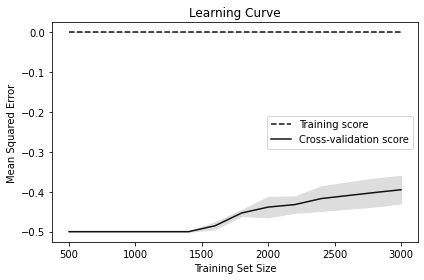

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Mean Squared Error"), plt.legend(loc="best")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf =tree.DecisionTreeClassifier()

In [ ]:
from scipy.stats import expon
from sklearn import tree
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

pos_label = 1
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'precision':make_scorer(precision_score, pos_label=pos_label)
           , 'recall':make_scorer(recall_score, pos_label=pos_label), 'f1':make_scorer(f1_score, pos_label=pos_label)}
params = {'max_leaf_nodes': list(range(2, 20)), 'min_samples_split': [2, 3, 4],'criterion': ['gini', 'entropy']}

svc_reg_gs = GridSearchCV(clf, param_grid=params, n_jobs=-1, verbose=1, cv=5,scoring=scoring,refit='Accuracy')
svc_reg_gs.fit(X_train, Y_train)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19],
                         'min_samples_split': [2, 3, 4]},
             refit='Accuracy',
             scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score, pos_label=1),
                      'precision': make_scorer(precision_score, pos_label=1),
                      'recall': make_scorer(recall_score, pos_label=1)},
             verbose=1)

In [ ]:
print(svc_reg_gs.best_params_)
print(svc_reg_gs.best_score_)

{'criterion': 'entropy', 'max_leaf_nodes': 18, 'min_samples_split': 2}
0.6900000000000001


In [ ]:
from sklearn import tree
from sklearn.model_selection import learning_curve

clf =tree.DecisionTreeClassifier(max_leaf_nodes= 18, min_samples_split= 2,criterion= 'entropy')

train_sizes = [500,600,700,800,900,1000,1200,1400,1600,1800,2000,2200,2400,2800,3000]
train_sizes, train_scores, test_scores = learning_curve(estimator = clf,
                                                              X = X,y = Y,
                                                              train_sizes = train_sizes,
                                                              scoring = 'neg_mean_squared_error')

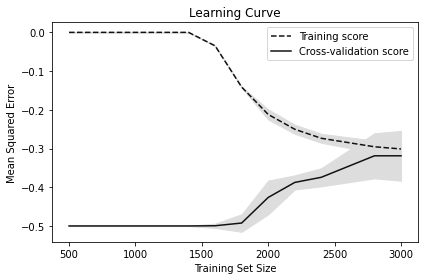

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Mean Squared Error"), plt.legend(loc="best")
plt.tight_layout()
plt.show()


In [ ]:
X =np.column_stack((testdata["fasttext_sent"],testdata["min_sim"],testdata["angry"],testdata["sad"],testdata["fear"],testdata["happy"],testdata["surprise"]))
Y = testdata["veracity"].tolist()
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0,train_size=2800)
print(X_train.shape)

(2800, 7)


In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_leaf_nodes= 18, min_samples_split= 2,criterion= 'entropy')
clf = clf.fit(X_train, Y_train)

In [ ]:
Y_pre=clf.predict(X_test)
a=clf.predict_proba(X_test)
Y_pre,Y_test,X_test=set_bound(Y_pre,Y_test,X_test,a,0.7)

In [ ]:
# a
Y_pre

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
# clf.predict_proba([[2., 2.]])
# Y_pre=clf.predict(X_test)
# tree.plot_tree(clf) 

In [ ]:
list(set(Y_pre))
# list(set(Y_test))

[0, 1, 2]

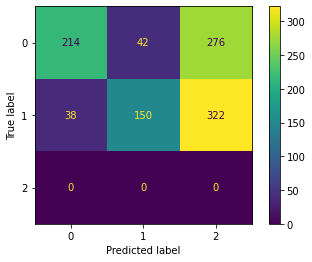

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
cm=confusion_matrix(Y_test, Y_pre)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= np.asarray([0,1,2]))
disp.plot()

In [ ]:
# from sklearn.metrics import recall_score, precision_score,accuracy_score
print("For Fake:\n")
print("Recall",recall_score(Y_test, Y_pre, pos_label=1,average="weighted"))
print("Precision",precision_score(Y_test,Y_pre, pos_label = 1,average="weighted"))
print("\nFor True:\n")
print("Recall",recall_score(Y_test, Y_pre, pos_label=0,average="weighted"))
print("Precision",precision_score(Y_test,Y_pre, pos_label = 0,average="weighted"))
print("\nAccuracy",accuracy_score(Y_test, Y_pre))
print("\nroc_auc_score",roc_auc_score(Y_test, Y_pre))

For Fake:

Recall 0.3493282149712092
Precision 0.8159455640861591

For True:

Recall 0.3493282149712092
Precision 0.8159455640861591

Accuracy 0.3493282149712092

roc_auc_score 0.6125018428424001


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' 

In [ ]:
len(Y_pre[Y_pre==1])

192

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


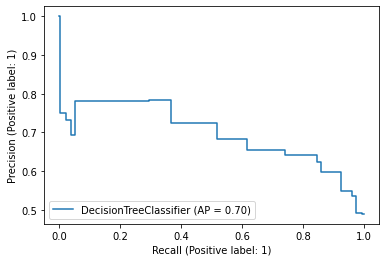

In [ ]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(clf,X_test, Y_test)

### SGD

In [ ]:
X =np.column_stack((testdata["fasttext_sent"],testdata["min_sim"],testdata["angry"],testdata["sad"],testdata["fear"],testdata["happy"],testdata["surprise"]))
Y = testdata["veracity"].tolist()
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0,train_size=2800)
print(X_train.shape)

(2800, 7)


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf =SGDClassifier()

In [ ]:
clf = clf.fit(X_train, Y_train)

In [ ]:
# clf.predict_proba([[2., 2.]])
Y_pre=clf.predict(X_test)
a=clf.predict_proba(X_test)
# Y_pre,Y_test,X_test=set_bound(Y_pre,Y_test,X_test,a,0.75)

AttributeError: ignored

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


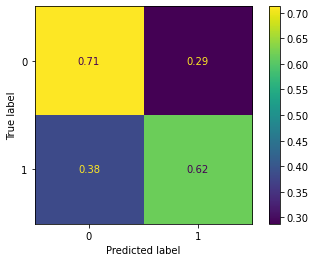

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(Y_test, Y_pre)
plot_confusion_matrix(clf, X_test, Y_test, normalize='true')

In [ ]:
from sklearn.metrics import recall_score, precision_score,accuracy_score
print("For Fake:\n")
print("Recall",recall_score(Y_test, Y_pre, pos_label=1))
print("Precision",precision_score(Y_test,Y_pre, pos_label = 1))
print("\nFor True:\n")
print("Recall",recall_score(Y_test, Y_pre, pos_label=0))
print("Precision",precision_score(Y_test,Y_pre, pos_label = 0))
print("\nAccuracy",accuracy_score(Y_test, Y_pre))
print("\nroc_auc_score",roc_auc_score(Y_test, Y_pre))

For Fake:

Recall 0.6176470588235294
Precision 0.6730769230769231

For True:

Recall 0.7124060150375939
Precision 0.6602787456445993

Accuracy 0.6660268714011516

roc_auc_score 0.6650265369305617


In [ ]:
from scipy.stats import expon
from sklearn import tree
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

pos_label = 1
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'precision':make_scorer(precision_score, pos_label=pos_label)
           , 'recall':make_scorer(recall_score, pos_label=pos_label), 'f1':make_scorer(f1_score, pos_label=pos_label)}

params = {'loss':[ 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
          'penalty': ['l2', 'l1', 'elasticnet'],'alpha':[0.00001,0.0001,0.001,0.01,0.1],
          'max_iter':np.arange(100,1000,100)}

svc_reg_gs = GridSearchCV(clf, param_grid=params, n_jobs=-1, verbose=1, cv=5,scoring=scoring,refit='Accuracy')
svc_reg_gs.fit(X_train, Y_train)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1],
                         'loss': ['log', 'modified_huber', 'squared_hinge',
                                  'perceptron'],
                         'max_iter': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
                         'penalty': ['l2', 'l1', 'elasticnet']},
             refit='Accuracy',
             scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score, pos_label=1),
                      'precision': make_scorer(precision_score, pos_label=1),
                      'recall': make_scorer(recall_score, pos_label=1)},
             verbose=1)

In [ ]:
print(svc_reg_gs.best_params_)
print(svc_reg_gs.best_score_)

{'alpha': 0.0001, 'loss': 'log', 'max_iter': 200, 'penalty': 'elasticnet'}
0.6689285714285715


In [ ]:
X =np.column_stack((testdata["fasttext_sent"],testdata["min_sim"],testdata["angry"],testdata["sad"],testdata["fear"],testdata["happy"],testdata["surprise"]))
Y = testdata["veracity"].tolist()
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0,train_size=2800)
print(X_train.shape)

(2800, 7)


In [ ]:
from sklearn import tree
from sklearn.model_selection import learning_curve

clf =SGDClassifier(alpha= 0.001, loss= 'log', max_iter=300, penalty= 'l1')

train_sizes = [500,1000,1500,2000,2500,3000]
train_sizes, train_scores, test_scores = learning_curve(estimator = clf,
                                                              X = X,y = Y,
                                                              train_sizes = train_sizes,
                                                              scoring = 'neg_mean_squared_error')

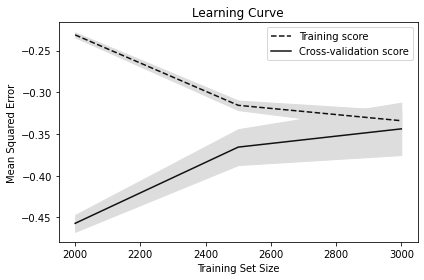

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Mean Squared Error"), plt.legend(loc="best")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn import tree
clf = SGDClassifier(alpha= 0.001, loss= 'log', max_iter= 300, penalty= 'l1')
clf = clf.fit(X_train, Y_train)
Y_pre=clf.predict(X_test)

In [ ]:
a=clf.predict_proba(X_test)
Y_pre,Y_test,X_test=set_bound(Y_pre,Y_test,X_test,a,0.75)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


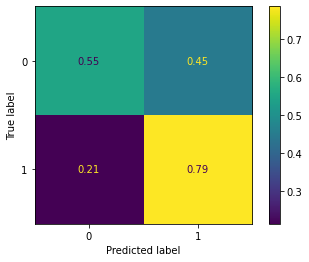

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(Y_test, Y_pre)
plot_confusion_matrix(clf, X_test, Y_test, normalize='true')

In [ ]:
from sklearn.metrics import recall_score, precision_score,accuracy_score
print("For Fake:\n")
print("Recall",recall_score(Y_test, Y_pre, pos_label=1,average="weighted"))
print("Precision",precision_score(Y_test,Y_pre, pos_label = 1,average="weighted"))
print("\nFor True:\n")
print("Recall",recall_score(Y_test, Y_pre, pos_label=0,average="weighted"))
print("Precision",precision_score(Y_test,Y_pre, pos_label = 0,average="weighted"))
print("\nAccuracy",accuracy_score(Y_test, Y_pre))
print("\nroc_auc_score",roc_auc_score(Y_test, Y_pre))

For Fake:

Recall 0.16794625719769674
Precision 0.8523216144501471

For True:

Recall 0.16794625719769674
Precision 0.8523216144501471

Accuracy 0.16794625719769674

roc_auc_score 0.47834291611381397


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' 

In [ ]:
len(Y_pre)

1042

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


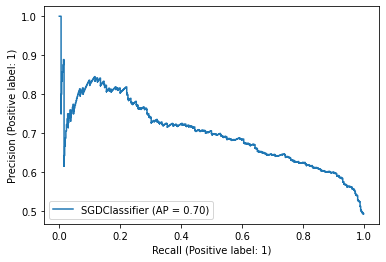

In [ ]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(clf,X_test, Y_test)

### Random Forest

In [ ]:
testdata.shape

(3842, 26)

In [ ]:
X =np.column_stack((testdata["fasttext_sent"],testdata["min_sim"],testdata["angry"],testdata["sad"],testdata["fear"],testdata["happy"],testdata["surprise"]))
Y = testdata["veracity"].tolist()
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0,train_size=2800)
print(X_train.shape)

(2800, 7)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

clf = clf.fit(X_train, Y_train)
Y_pre=clf.predict(X_test)
# a=clf.predict_proba(X_test)
# Y_pre,Y_test,X_test=set_bound(Y_pre,Y_test,X_test,a,0.75)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


For Fake:

Recall 0.6411764705882353
Precision 0.615819209039548

For True:

Recall 0.6165413533834586
Precision 0.6418786692759295

Accuracy 0.6285988483685221


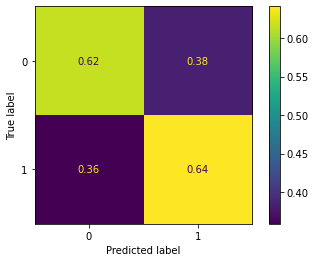

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(Y_test, Y_pre)
plot_confusion_matrix(clf, X_test, Y_test, normalize='true')
from sklearn.metrics import recall_score, precision_score,accuracy_score
print("For Fake:\n")
print("Recall",recall_score(Y_test, Y_pre, pos_label=1))
print("Precision",precision_score(Y_test,Y_pre, pos_label = 1))
print("\nFor True:\n")
print("Recall",recall_score(Y_test, Y_pre, pos_label=0))
print("Precision",precision_score(Y_test,Y_pre, pos_label = 0))
print("\nAccuracy",accuracy_score(Y_test, Y_pre))
# print("\nroc_auc_score",roc_auc_score(Y_test, Y_pre))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


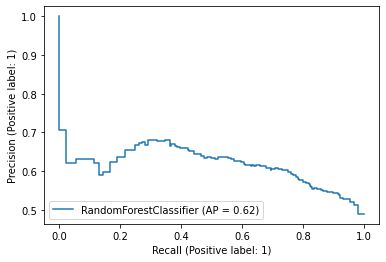

In [ ]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(clf,X_test, Y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import expon
from sklearn import tree
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50,60,70,80,100],
    'max_features': [2, 3,4],
    'min_samples_leaf': [12,13,14,15],
    'min_samples_split': [8,10,12,14,15,16,18],
    'n_estimators': [70,80,100, 200, 300,400]
}
# Create a based model
# rf = RandomForestRegressor()
# Instantiate the grid search model
pos_label = 1
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'precision':make_scorer(precision_score, pos_label=pos_label)
           , 'recall':make_scorer(recall_score, pos_label=pos_label), 'f1':make_scorer(f1_score, pos_label=pos_label)}

grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2,scoring=scoring,refit="Accuracy")
grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 2520 candidates, totalling 7560 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_depth=80, max_features=2,
                                              min_samples_leaf=14,
                                              min_samples_split=18),
             n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [50, 60, 70, 80, 100],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [12, 13, 14, 15],
                         'min_samples_split': [8, 10, 12, 14, 15, 16, 18],
                         'n_estimators': [70, 80, 100, 200, 300, 400]},
             refit='Accuracy',
             scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score, pos_label=1),
                      'precision': make_scorer(precision_score, pos_label=1),
                      'recall': make_scorer(recall_score, pos_label=1)},
             verbose=2)

In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'bootstrap': True, 'max_depth': 100, 'max_features': 2, 'min_samples_leaf': 13, 'min_samples_split': 12, 'n_estimators': 100}
0.6975024729694682


In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 14, 'min_samples_split': 10, 'n_estimators': 200}
0.6975020904529226


In [ ]:
X =np.column_stack((testdata["fasttext_sent"],testdata["min_sim"],testdata["angry"],testdata["sad"],testdata["fear"],testdata["happy"],testdata["surprise"]))
Y = testdata["veracity"].tolist()
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0,train_size=2800)
print(X_train.shape)

(2800, 7)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(bootstrap= True,max_depth= 100,max_features= 2,min_samples_leaf= 13, min_samples_split= 12,n_estimators= 100)

clf = clf.fit(X_train, Y_train)
Y_pre=clf.predict(X_test)
# a=clf.predict_proba(X_test)
# Y_pre,Y_test,X_test=set_bound(Y_pre,Y_test,X_test,a,0.75)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


For Fake:

Recall 0.6861804222648752
Precision 0.6880023648980546

For True:

Recall 0.6861804222648752
Precision 0.6880023648980546

Accuracy 0.6861804222648752


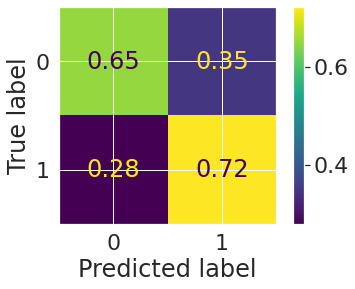

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(Y_test, Y_pre)
plot_confusion_matrix(clf, X_test, Y_test, normalize='true')
from sklearn.metrics import recall_score, precision_score,accuracy_score
print("For Fake:\n")
print("Recall",recall_score(Y_test, Y_pre, pos_label=1,average="weighted"))
print("Precision",precision_score(Y_test,Y_pre, pos_label = 1,average="weighted"))
print("\nFor True:\n")
print("Recall",recall_score(Y_test, Y_pre, pos_label=0,average="weighted"))
print("Precision",precision_score(Y_test,Y_pre, pos_label = 0,average="weighted"))
print("\nAccuracy",accuracy_score(Y_test, Y_pre))
# print("\nroc_auc_score",roc_auc_score(Y_test, Y_pre))

In [ ]:
# import pickle
# filename = '/content/drive/MyDrive/NLP_News/nlp_model.sav'
# pickle.dump(clf, open(filename, 'wb'))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


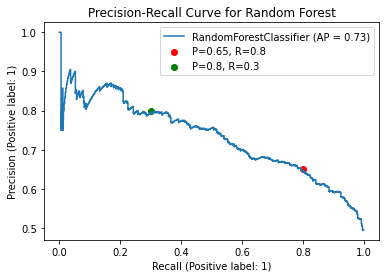

In [ ]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(clf,X_test, Y_test)
plt.title("Precision-Recall Curve for Random Forest")
plt.scatter(0.8,0.65,c="r",label="P=0.65, R=0.8")
plt.scatter(0.3,0.8,c="g",label="P=0.8, R=0.3")
plt.legend()

Text(56.499999999999986, 0.5, 'Predicted Class')

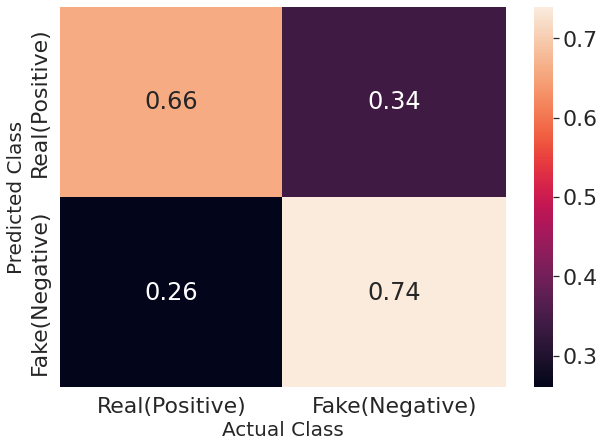

In [ ]:
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
sn.set(font_scale=2)
a=[[0.66,0.34],[0.26,0.74]]
df_cm = pd.DataFrame(a, index = [i for i in ["Real(Positive)","Fake(Negative)"]],
                  columns = [i for i in ["Real(Positive)","Fake(Negative)"]])
plt.figure(figsize = (10,7))

p=sn.heatmap(df_cm, annot=True)
p.set_xlabel("Actual Class",fontsize=20)
p.set_ylabel("Predicted Class",fontsize=20)
# sn.xlabel()

In [ ]:
# pres=pd.read_csv("/content/drive/MyDrive/NLP_News/president_0_5jan2021_combined.csv")
# ind_l=[6,8,28,171,183,311,487,668,689,692]
# pres=pres.iloc[ind_l]
# pres.reset_index(inplace=True,drop=True)
# pres.to_csv("/content/drive/MyDrive/NLP_News/president_0_5jan2021_combined.csv")

In [ ]:
# pres.tweet

In [ ]:
# pres=pd.read_csv("/content/drive/MyDrive/NLP_News/michigan_1_18nov2020_combined.csv")
# ind_l=[181,443,446]
# pres=pres.iloc[ind_l]
# pres.reset_index(inplace=True,drop=True)
# pres.to_csv("/content/drive/MyDrive/NLP_News/michigan_1_18nov2020_combined.csv")

In [ ]:
# pres=pd.read_csv("/content/drive/MyDrive/NLP_News/federal_2_1may2018_combined.csv")
# ind_l=[0,4]
# pres=pres.iloc[ind_l]
# pres.reset_index(inplace=True,drop=True)
# pres.to_csv("/content/drive/MyDrive/NLP_News/federal_2_1may2018_combined.csv")

In [ ]:
# pres=pd.read_csv("/content/drive/MyDrive/NLP_News/covid-19_7_21may2021_combined.csv")
# ind_l=[13,181,182,201,203,229]
# pres=pres.iloc[ind_l]
# pres.reset_index(inplace=True,drop=True)
# pres.to_csv("/content/drive/MyDrive/NLP_News/covid-19_7_21may2021_combined.csv")

In [ ]:
pres.tweet

0    addressing the stop the steal crowd president ...
1    false nothing in the constitution nor any law ...
2    president trump tweeted that the vice presiden...
3    vice president mike pence on tuesday told pres...
4    president trump is pressuring vice president p...
5    vice president mike pence on tuesday told pres...
6    vice president mike pence will play a crucial ...
7    breaking vice president mike pence defies pres...
8    an apfactcheck makes clear that vice president...
9    prior to the violence that disrupted congress ...
Name: tweet, dtype: object

In [ ]:
pres=pd.read_csv("/content/drive/MyDrive/NLP_News/president_0_5jan2021_combined.csv")
mich=pd.read_csv("/content/drive/MyDrive/NLP_News/michigan_1_18nov2020_combined.csv")
fed=pd.read_csv("/content/drive/MyDrive/NLP_News/federal_2_1may2018_combined.csv")
cov=pd.read_csv("/content/drive/MyDrive/NLP_News/covid-19_7_21may2021_combined.csv")

In [ ]:
mich_t=["michigan just refused to certify election results"]
pres_t=["vise president has power reject fraudulently chose elector"]
fed_t=["you know what Amazon paid in federal income taxes last year zero"]
cov_t=["today president biden signed covid hate crimes bill into law"]

In [ ]:
ft1 = fasttext.load_model('cc.en.300.bin')
ft1.get_dimension()

300

In [ ]:
import fasttext
ft2 = fasttext.load_model('/content/drive/MyDrive/NLP_News/model_amzn.bin')

In [ ]:
a = ft1.get_sentence_vector(pres_t[0])
sim=[]
for i in range(pres.shape[0]):
  b= ft1.get_sentence_vector(pres.tweet[i])
  sim.append(cos_sim(a,b))
print(sim)
print(ft2.predict(pres_t))

sent=[]
for i in range(pres.shape[0]):
  b= ft2.predict(pres.tweet[i])
  sent.append(b)
print(sent)

print(te.get_emotion(pres_t[0]))

[0.71440935, 0.6815481, 0.82788986, 0.74636286, 0.72394294, 0.74636286, 0.68898886, 0.76006585, 0.71117175, 0.6423468]
([['__label__1']], [array([0.9999813], dtype=float32)])
[(('__label__1',), array([0.93267179])), (('__label__1',), array([1.00000715])), (('__label__1',), array([1.0000037])), (('__label__1',), array([0.98571628])), (('__label__1',), array([0.99701422])), (('__label__1',), array([0.98571628])), (('__label__1',), array([0.50448662])), (('__label__1',), array([0.99829406])), (('__label__1',), array([0.96329719])), (('__label__1',), array([0.94407296]))]
{'Happy': 0.0, 'Angry': 1.0, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 0.0}


In [ ]:
clf.predict(np.array([0,0.6124307,1.0,0.0,0.0,0.0,0.0]).reshape(1, -1))

array([1])

In [ ]:
a = ft1.get_sentence_vector(mich_t[0])
sim=[]
for i in range(mich.shape[0]):
  b= ft1.get_sentence_vector(mich.tweet[i])
  sim.append(cos_sim(a,b))
print(sim)
print(ft2.predict(mich_t))

sent=[]
for i in range(mich.shape[0]):
  b= ft2.predict(mich.tweet[i])
  sent.append(b)
print(sent)

print(te.get_emotion(mich_t[0]))

[0.7811301, 0.6673635, 0.76560575]
([['__label__1']], [array([1.0000099], dtype=float32)])
[(('__label__1',), array([0.97261035])), (('__label__1',), array([0.92956799])), (('__label__1',), array([0.50376517]))]
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 1.0, 'Fear': 0.0}


In [ ]:
clf.predict(np.array([0,0.6673635,0.0,1.0,0.0,0.0,0.0]).reshape(1, -1))

array([1])

In [ ]:
a = ft1.get_sentence_vector(fed_t[0])
sim=[]
for i in range(fed.shape[0]):
  b= ft1.get_sentence_vector(fed.tweet[i])
  sim.append(cos_sim(a,b))
print(sim)
print(ft2.predict(fed_t))

sent=[]
for i in range(fed.shape[0]):
  b= ft2.predict(fed.tweet[i])
  sent.append(b)
print(sent)

print(te.get_emotion(fed_t[0]))

[0.81532013, 0.97506624]
([['__label__1']], [array([0.99909294], dtype=float32)])
[(('__label__1',), array([0.99899405])), (('__label__1',), array([0.99926287]))]
{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad': 0, 'Fear': 0}


In [ ]:
clf.predict(np.array([0,0.81532013,0.0,0.0,0.0,0.0,0.0]).reshape(1, -1))

array([0])

In [ ]:
a = ft1.get_sentence_vector(cov_t[0])
sim=[]
for i in range(cov.shape[0]):
  b= ft1.get_sentence_vector(cov.tweet[i])
  sim.append(cos_sim(a,b))
print(sim)
print(ft2.predict(cov_t))

sent=[]
for i in range(cov.shape[0]):
  b= ft2.predict(cov.tweet[i])
  sent.append(b)
print(sent)

print(te.get_emotion(cov_t[0]))

[0.7601865, 0.7731112, 0.7571038, 0.7558106, 0.6764957, 0.7430392]
([['__label__1']], [array([0.7557746], dtype=float32)])
[(('__label__2',), array([0.84708154])), (('__label__1',), array([0.70699686])), (('__label__1',), array([0.5636217])), (('__label__1',), array([0.7181536])), (('__label__1',), array([0.93848467])), (('__label__1',), array([0.98872918]))]
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.25, 'Sad': 0.5, 'Fear': 0.25}


In [ ]:
clf.predict(np.array([0,0.7538006,0.0,0.0,0.25,0.0,0.25]).reshape(1, -1))

array([1])